<a href="https://colab.research.google.com/github/dhirensk/ai/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN classifier on cats vs dogs. Using callbacks functions to resume training


**ModelCheckpoint**

**EarlyStopping **







## Importing a Kaggle Dataset

If you have an external dataset on a remote server, you can curl/wget the dataset or lets say you want to work directly with dataset on kaggle platform

### Install kaggle api

In [0]:
!pip install kaggle

    100% |████████████████████████████████| 61kB 2.4MB/s 
    100% |████████████████████████████████| 245kB 7.3MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


### Configure Kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp '/content/gdrive/My Drive/kaggle.json' ~/.kaggle

### Downloading and using Kaggle Dataset

In [0]:
!kaggle datasets download --unzip dhirensk/cats-vs-dogs-training8000test2000

 93% 203M/218M [00:01<00:00, 127MB/s]
100% 218M/218M [00:01<00:00, 140MB/s]


In [0]:
!ls -d dataset/*
!find dataset -type f | wc -l

dataset/single_prediction  dataset/test_set  dataset/training_set
10002


## Using Google Drive to store your Model

### Mount the google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### You can also use google drive folder as your dataset source


Access google drive base directory by prefixing  **/content/gdrive/'My Drive'/**

Copying the google drive file   **/datasets/dataset_cats_dogs_small.tar** into current folder

In [0]:
!cp /content/gdrive/'My Drive'/datasets/dataset_cats_dogs_small.tar .

### Untar the dataset

In [0]:
!tar -xf dataset_cats_dogs_small.tar

In [4]:
!ls -d dataset/*/*
!find dataset -type f | wc -l

dataset/single_prediction/cat_or_dog_1.jpg  dataset/test_set/dogs
dataset/single_prediction/cat_or_dog_2.jpg  dataset/training_set/cats
dataset/test_set/cats			    dataset/training_set/dogs
10002


### Building the Model

In [5]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D,Flatten,Dense,BatchNormalization, Dropout
from keras.optimizers import SGD, Adamax, Adam


K.set_image_data_format('channels_last')
#Initialize the CNN
classifier = Sequential()

#Adding the layers to CNN
#Adding 1st CNN layer
classifier.add(Conv2D(64,(3,3), strides=(1,1),padding='same', input_shape=(128,128,3), activation='relu'))
#classifier.add(BatchNormalization())
#classifier.add(Dropout(0.2))
classifier.add(MaxPool2D(pool_size=(2,2)))

#Adding 2nd CNN layer
classifier.add(Conv2D(64,(3,3), padding='same',activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
#classifier.add(Dropout(0.2))

#Adding 3rd CNN layer
classifier.add(Conv2D(64,(3,3), padding='same', activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
#classifier.add(Dropout(0.2))

#Adding 4th CNN layer
classifier.add(Conv2D(64,(3,3), padding='same', activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
#classifier.add(Dropout(0.2))

#Flatten the CNN output
classifier.add(Flatten())

#Adding 1st Hidden layer
classifier.add(Dense(64,activation='relu'))
classifier.add(BatchNormalization())
#classifier.add(Dropout(0.5))

#Adding 2nd Hidden layer
classifier.add(Dense(64,activation='relu'))
classifier.add(BatchNormalization())
#classifier.add(Dropout(0.2))

#Adding 3rd Hidden layer
classifier.add(Dense(64,activation='relu'))
#classifier.add(BatchNormalization())
#classifier.add(Dropout(0.2))

#Adding Output layer
classifier.add(Dense(1,activation='sigmoid'))

# Compiling the CNN using adam optimizer
classifier.compile(optimizer= 'adam',loss='binary_crossentropy',metrics=['accuracy'])

Using TensorFlow backend.


### Load existing model weights

Load Existing Model weights and not entire model.
if we make changes to the model above then load model will overwrite our changes above
so we only add weights and if the weights correspond to old model then we train from beginning
we also overwrite the entire saved model when we see improvements in validation loss

In [0]:
!mkdir -p "/content/gdrive/My Drive/Colab Notebooks"

In [7]:
#Load Existing Model weights
import os.path
try :
    if os.path.isfile('/content/gdrive/My Drive/Colab Notebooks/CNN_model.h5'):
        classifier.load_weights('/content/gdrive/My Drive/Colab Notebooks/CNN_model.h5')
        print("loaded CNN_model.h5 from /content/gdrive/My Drive/Colab Notebooks/CNN_model.h5")
    else:
        print("No Model Weights found. Training from beginning")
except Exception as e:
    print(e)
    print("The model will be trained from beginning")

loaded CNN_model.h5 from /content/gdrive/My Drive/Colab Notebooks/CNN_model.h5


### Defining the callback functions

We use 2 callback functions ModelCheckpoint & EarlyStopping. Suppose we had already trained our classifier for 20/25 epochs. Next time if we resume training using saved weights the classifer will not improve much 
so there is no point in running the classifier for another 25 epochs and hence we include an earlystopping. With ModelCheckpoint we will save the complete model and not just the weights in CNN_model.h5

In [0]:
#lets train it for training accuracy instead of validation loss first
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/CNN_model.h5',monitor='acc',save_best_only=True,verbose=1, save_weights_only=False)
callback_list = [checkpoint]

We will use earlystopping later once we have a basic model ready

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/CNN_model.h5',monitor='val_loss',save_best_only=True,verbose=1, save_weights_only=False)
stopearly = EarlyStopping(monitor='val_loss',min_delta=0, patience=4, verbose=1)
callback_list = [checkpoint, stopearly]

### Training the Model

In [0]:
# Fitting the CNN
# Image Augmentation to avoid overfitting
import time
start_time = time.time()
#print(start_time)

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
        'dataset/training_set',
        target_size=(128, 128),      
        batch_size=32,
        class_mode='binary')

test_set = test_datagen.flow_from_directory(
        'dataset/test_set',
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary')
# so as to save history
history = classifier.fit_generator(
        training_set,
        steps_per_epoch=(8000/32),  
        epochs=10,
        validation_data=test_set,
        validation_steps=(2000/32),
        callbacks = callback_list)  

# print(history.history)
elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

loss = history.history['loss'][-1]
acc = history.history['acc'][-1]
print("Training Accuracy of last epoch =" +str(acc))
val_loss = history.history['val_loss'][-1]
val_acc = history.history['val_acc'][-1]
print('Validation/Test accuracy of last epoch =' + str(val_acc))



Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/10
250/250 [==============================] - 551s 2s/step - loss: 0.1204 - acc: 0.9540 - val_loss: 0.2774 - val_acc: 0.8970

Epoch 00001: acc improved from -inf to 0.95400, saving model to /content/gdrive/My Drive/Colab Notebooks/CNN_model.h5
Epoch 2/10
250/250 [==============================] - 562s 2s/step - loss: 0.1199 - acc: 0.9536 - val_loss: 0.2982 - val_acc: 0.8970

Epoch 00002: acc did not improve from 0.95400
Epoch 3/10
250/250 [==============================] - 555s 2s/step - loss: 0.1201 - acc: 0.9516 - val_loss: 0.4770 - val_acc: 0.8340

Epoch 00003: acc did not improve from 0.95400
Epoch 4/10
250/250 [==============================] - 571s 2s/step - loss: 0.1120 - acc: 0.9560 - val_loss: 0.3036 - val_acc: 0.8970

Epoch 00004: acc improved from 0.95400 to 0.95600, saving model to /content/gdrive/My Drive/Colab Notebooks/CNN_model.h5
Epoch 5/10
250/250 [=============================

### Saving the model as json and weights in HDF5 format
### Not required as we already saved the best model using callbacks

In [0]:
"""
# serialize model to JSON
model_json = classifier.to_json()
with open("/content/gdrive/My Drive/Colab Notebooks/CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
classifier.save_weights("/content/gdrive/My Drive/Colab Notebooks/CNN_model.h5")
print("Saved model weights and architecture to disk")

"""

### Testing on a single image
### Try cat_or_dog_1.jpg / cat_or_dog_2.jpg

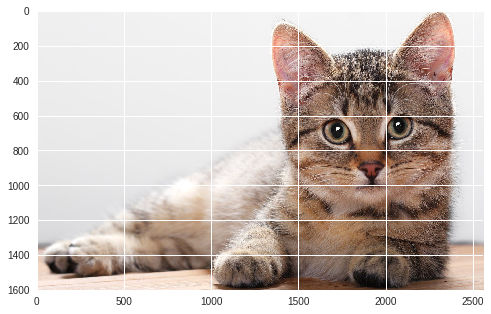

(1, 64, 64, 3)
[[0]]
predicted class for the test image is : cats


In [0]:
# later...
# test on a single test data
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as img
file = 'dataset/single_prediction/cat_or_dog_2.jpg'
Img = img.imread(file)
plt.imshow(Img)
plt.show()
test_image = image.load_img(file,target_size=(64,64))
test_image = image.img_to_array(test_image)

# add a dimension which represents 'm' for number of examples m =1 for single examples
test_image = np.expand_dims(test_image, axis=0)
print(test_image.shape)
prediction = classifier.predict_classes(test_image)
#[[1]] for dog,[[0]] for cat 
print(prediction)
classes = training_set.class_indices
#{'cats': 0, 'dogs': 1}
for key, value in classes.items():
    if (value == int(prediction)):
        print("predicted class for the test image is : " + str(key))

### Loading the model back from file and verify that prediction is matching

In [0]:

"""
# load json and create model
from keras.models import model_from_json
json_file = open('/content/gdrive/My Drive/Colab Notebooks/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
# returns an uncompiled model instance
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/Colab Notebooks/CNN_model.h5")
print("Loaded model from disk")
"""

from keras.models import load_model
loaded_model = load_model('CNN_model.h5',compile = False)


#find the accuracy of training set & test set which was used earlier
#You must compile a model before training/testing. Use `model.compile(optimizer, loss)`
loaded_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
loaded_model.evaluate(test_image,[[1]])
prediction2 = loaded_model.predict(test_image)
#loaded_model.summary()
for key, value in classes.items():
    if (value == int(prediction2)):
        print("predicted class for the test image is : " + str(key))

